In [1]:
import pandas as pd
import numpy as np

def import_dataset_from_file(path_to_file: str) -> pd.DataFrame:
    """
    Функция импортирования исходных данных.
    :param path_to_file: путь к загружаемому файлу;
    :return: структура данных.
    """
    dataset = pd.read_table(path_to_file, delim_whitespace=True, names=['x', 'y', 'z'])

    return dataset


def export_dataset_to_file(dataset: pd.DataFrame):
    """
    Функция экспортирования результата в файл result.txt.
    :param dataset: входная структура данных.
    """
    n, c = dataset.shape

    assert c == 3, 'Количество столбцов должно быть 3'
    assert n == 1196590, 'Количество строк должно быть 1196590'

    with open('/kaggle/working/Result.txt', 'w') as f:
        for i in range(n):
            f.write('%.2f %.2f %.5f\n' % (dataset.x[i], dataset.y[i], dataset.z[i]))


if __name__ == "__main__":
    pass
    # Вспомогательные данные, по которым производится моделирование
#     map_1_dataset = import_dataset_from_file("Data\\Map_1.txt")
#     map_2_dataset = import_dataset_from_file("Data\\Map_2.txt")
#     map_3_dataset = import_dataset_from_file("Data\\Map_3.txt")
#     map_4_dataset = import_dataset_from_file("Data\\Map_4.txt")
#     map_5_dataset = import_dataset_from_file("Data\\Map_5.txt")

    # Данные, по которым необходимо смоделировать
#     point_dataset = import_dataset_from_file("Data\\Point_dataset.txt")

    # Точки данных, в которые необходимо провести моделирование (сетка данных)
#     point_grid = import_dataset_from_file("Data\\Result_schedule.txt")

    # Блок вычислений
    # dataset = calc(point_grid)

    # Экспорт данных в файл (смотри Readme.txt)
    # export_dataset_to_file(dataset=dataset)

In [2]:
map_1 = import_dataset_from_file('/kaggle/input/hackaton-data/Map_1.txt')
map_2 = import_dataset_from_file('/kaggle/input/hackaton-data/Map_2.txt')
map_3 = import_dataset_from_file('/kaggle/input/hackaton-data/Map_3.txt')
map_4 = import_dataset_from_file('/kaggle/input/hackaton-data/Map_4.txt')
map_5 = import_dataset_from_file('/kaggle/input/hackaton-data/Map_5.txt')
point_dataset = import_dataset_from_file('/kaggle/input/hackaton-data/Point_dataset.txt')
point_grid = import_dataset_from_file('/kaggle/input/hackaton-data/Result_schedule.txt')
dfs = [map_1, map_2, map_3, map_4, map_5]

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

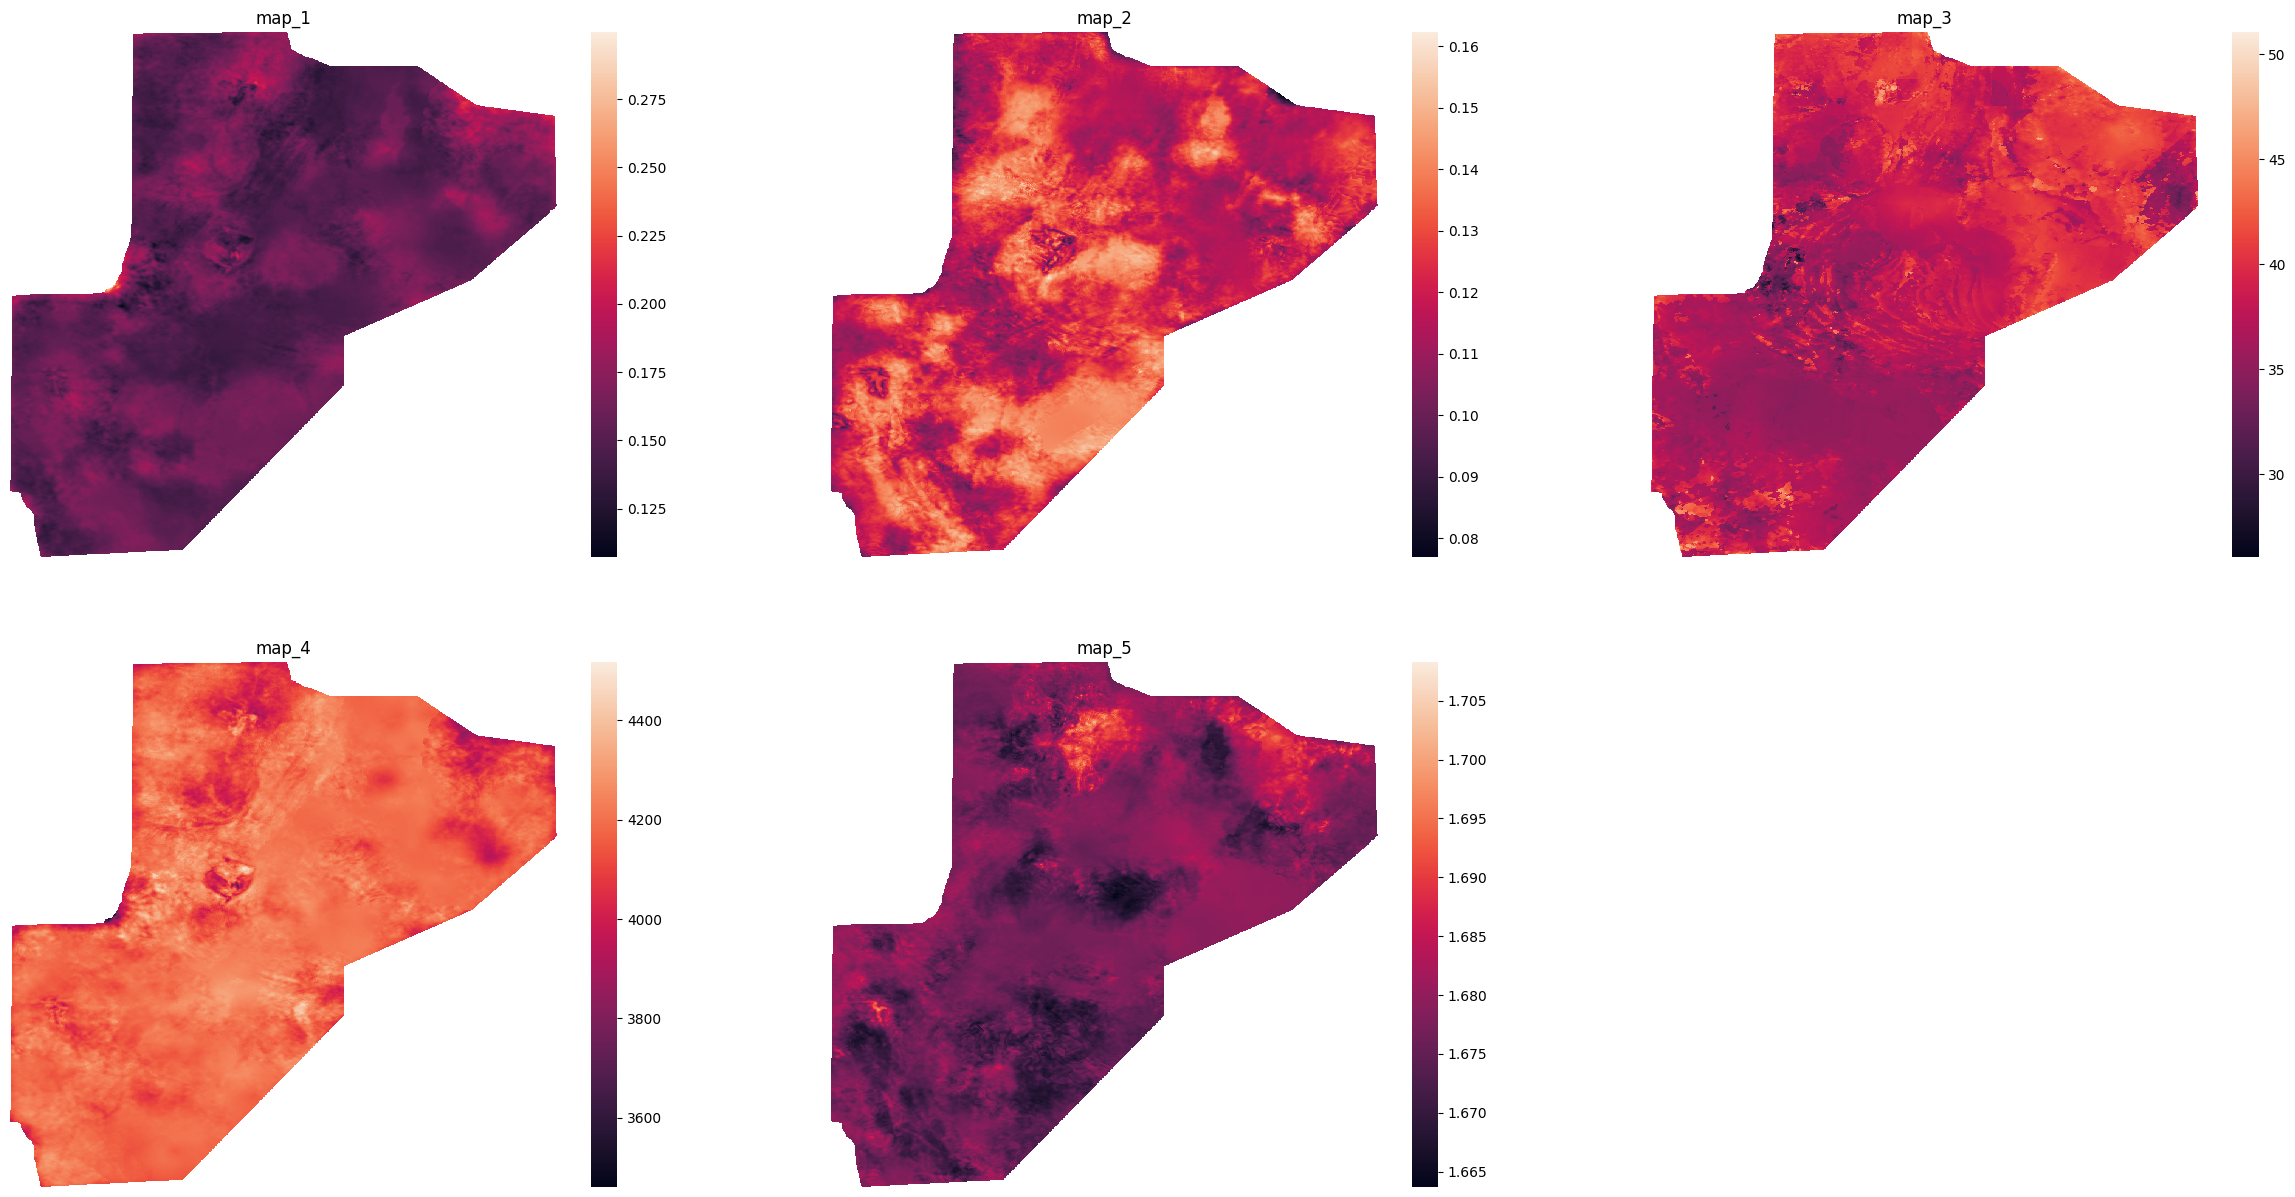

In [4]:
fig = plt.figure(figsize=(30,15))
for i, data in enumerate(dfs):
    ax = fig.add_subplot(2,3,i+1)
    map_img = data.pivot_table(index='x', columns='y', values='z')
    sns.heatmap(map_img)
    plt.title(f'map_{i+1}')
    plt.axis('off')
    

In [5]:
# XGBoost proven to be ineffective

# from xgboost import XGBRegressor
# from sklearn.metrics import mean_absolute_error
# models = [XGBRegressor(n_estimators=10000, 
#                        tree_method='gpu_hist', 
#                        early_stopping_rounds=25,
#                        learning_rate=0.1) for i in range(5)]
# for model, df in zip(models, dfs):
#     x = df[['x', 'y']]
#     y = df['z']
#     model.fit(x, y, eval_set=[(x, y)], verbose=False)
#     print(mean_absolute_error(model.predict(x), y))
    #print(cross_val_score(model, x, y, cv=5, n_jobs=-1, scoring='neg_mean_squared_error').mean())
    

In [6]:
# Random Forest showed best score

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
models2 = [RandomForestRegressor(n_estimators=25) for i in range(5)]
for model, df in zip(models2, dfs):
    x = df[['x', 'y']]
    y = df['z']
    model.fit(x, y)
    print(mean_absolute_error(model.predict(x), y))

0.00010691251430219114
0.00013443980860764154
0.04602746600150695
0.851450627088998
5.382757236762776e-05


In [7]:
# Decision trees showed least error on training data

from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error
models3 = [DecisionTreeRegressor() for i in range(5)]
for model, df in zip(models3, dfs):
    x = df[['x', 'y']]
    y = df['z']
    model.fit(x,y)
    print(mean_absolute_error(model.predict(x), y))

6.031324543824686e-22
2.308141508117524e-21
0.0
0.0
7.176348311067711e-19


In [8]:
x = point_dataset[['x', 'y']]
for i, model in enumerate(models2):
    point_dataset[f'map_{i+1}'] = model.predict(x)
test = point_grid.copy()
x = test[['x', 'y']]
for i, model in enumerate(models2):
    test[f'map_{i+1}'] = model.predict(x)
point_dataset['map_sum'] = point_dataset['map_1'] + point_dataset['map_2'] + point_dataset['map_3'] + point_dataset['map_4'] + point_dataset['map_5']
point_dataset['map_prod'] = point_dataset['map_1'] * point_dataset['map_2'] * point_dataset['map_3'] * point_dataset['map_4'] * point_dataset['map_5']
test['map_sum'] = test['map_1'] + test['map_2'] + test['map_3'] + test['map_4'] + test['map_5']
test['map_prod'] = test['map_1'] * test['map_2'] *test['map_3'] * test['map_4'] * test['map_5']

In [9]:
# XGBoost showed less score in submissions than Random Forest

# from sklearn.model_selection import train_test_split, cross_val_score
# from xgboost import XGBRegressor
# class UPDRegr(XGBRegressor):
#     def fit(self, x, y):
#         super().fit(x, y, eval_set=[(x, y)], verbose=False)
# final_regressor = UPDRegr(n_estimators=10000, 
#                                early_stopping_rounds=20, 
#                                learning_rate=0.01,
#                                tree_method='gpu_hist')
# x = point_dataset.drop(['z'], axis=1)
# y = point_dataset['z']
# x_test = test.drop(['z'], axis=1)
# print(cross_val_score(final_regressor, x, y, cv=10, scoring='neg_mean_squared_error').mean())

In [10]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score
final_regressor = RandomForestRegressor(n_estimators=500, max_depth=23)
x = point_dataset.drop(['z'], axis=1)
y = point_dataset['z']
x_test = test.drop(['z'], axis=1)
print(cross_val_score(final_regressor, x, y, cv=10, scoring='neg_mean_squared_error').mean())

-1.0166580644040233


In [11]:
final_regressor.fit(x, y)
preds = final_regressor.predict(x_test)
point_grid['z'] = preds
export_dataset_to_file(point_grid)

In [12]:
point_grid

,x,y,z
0,68239.21,24467.0,12.513614
1,68251.71,24467.0,12.513048
2,68264.21,24467.0,12.496102
3,68276.71,24467.0,12.493600
4,68289.21,24467.0,12.499357
...,...,...,...
1196585,53264.21,46942.0,14.815819
1196586,53276.71,46942.0,14.830667
1196587,53289.21,46942.0,14.932019
1196588,53301.71,46942.0,15.005826


# MSE score: 1.43